<a href="https://colab.research.google.com/github/zeekgwang/WM-811K/blob/main/classification/WM811K_efficientB0_augment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from os.path import join

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image

np.random.seed(0)

In [ ]:
data_path = "./drive/MyDrive/wafer/wm811k/"
print(os.listdir(data_path))

['LSWMD.pkl', 'y_3000.npy', 'x_3000.npy', 'y_3500.npy', 'x_3500.npy', 'x_3500_128.npy', 'y_3500_128.npy']


In [ ]:
x_3500 = np.load(data_path + "x_3500_128.npy")
y_3500 = np.load(data_path + "y_3500_128.npy")
y_3500 = y_3500.argmax(axis=1).reshape(-1,1)

In [ ]:
print(f"x_3500.shape : {x_3500.shape}")
print(f"y_3500.shape : {y_3500.shape}")

x_3500.shape : (3500, 3, 128, 128)
y_3500.shape : (3500, 1)


In [ ]:
x_train, x_test, y_train, y_test \
= train_test_split(x_3500, y_3500,
                   test_size = 0.2,
                   shuffle=True)

In [ ]:
print(f"x_train.shape : {x_train.shape}")
print(f"x_test.shape : {x_test.shape}")
print(f"y_train.shape : {y_train.shape}")
print(f"y_test.shape : {y_test.shape}")

x_train.shape : (2800, 3, 128, 128)
x_test.shape : (700, 3, 128, 128)
y_train.shape : (2800, 1)
y_test.shape : (700, 1)


In [ ]:
batch_size = 128

In [ ]:
def get_device():
  if torch.cuda.is_available():
    device = 'cuda:0'
  else:
    device = 'cpu'
  return device

device = get_device()
print(device)

cuda:0


In [ ]:
class WaferMapDataset(Dataset):
  def __init__(self, x, y, transform = None):
    super().__init__()
    self.x = x
    self.y = y
    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    x_idx = self.x[idx]
    # print(x_idx.shape)
    image = Image.fromarray((x_idx * 255).astype(np.uint8).transpose((1,2,0)))    
    # print(np.array(image).shape)
    if self.transform:
      image = self.transform(image)

    x_idx = np.array(image) / 255
    x_idx = x_idx.transpose((2,0,1))
    # print(x_idx.shape)
    return torch.FloatTensor(x_idx), torch.LongTensor(self.y[idx])

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30)
])

In [ ]:
waferMapDataset = WaferMapDataset(x_train, y_train, transform = transform)
# waferMapDataset = WaferMapDataset(x_train, y_train)

In [ ]:
train_loader = DataLoader(waferMapDataset, batch_size=batch_size)

In [ ]:
data_iter = iter(train_loader)
x_head, y_head = data_iter.next()

In [ ]:
print(f"type(x_head) : {type(x_head)},\ntype(y_head) : {type(y_head)}")

type(x_head) : <class 'torch.Tensor'>,
type(y_head) : <class 'torch.Tensor'>


In [ ]:
print(f"x_head.shape : {x_head.shape},\ny_head.shape : {y_head.shape}")

x_head.shape : torch.Size([128, 3, 128, 128]),
y_head.shape : torch.Size([128, 1])


Text(0.5, 1.0, 'tensor([3])')

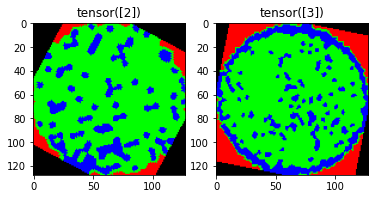

In [ ]:
fig = plt.figure()

ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.imshow(np.transpose(x_head[0], (1,2,0)))
ax1.set_title(y_head[0])


ax2.imshow(np.transpose(x_head[1], (1,2,0)))
ax2.set_title(y_head[1])

In [ ]:
!pip3 install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=461f13ca74137cff2bcd7186917e2e5c6ccc37ae2b58099c127dfd7f72ba2b84
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


In [ ]:
def get_model(model_name='efficientnet-b0'):
    model = EfficientNet.from_pretrained(model_name)
    del model._fc
    # # # use the same head as the baseline notebook.
    model._fc = nn.Linear(1280, 7)
    return model

In [ ]:
model = get_model().to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [ ]:
# from torchsummary import summary as summary_
# summary_(model.to(device), (3,128,128))

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
x_test = torch.FloatTensor(x_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

In [ ]:
for epoch in range(20):

    running_loss = 0.0
    accuracy= 0.0

    for b, (x, y) in enumerate(train_loader):
        model.train()
        
        x = x.to(device)
        y = y.reshape(-1).to(device)
        
        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(x)

        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()

        # if(b == len(train_loader) - 1):
        #   model.eval()
        #   prediction = model(x_test)
        #   correct_prediction = torch.argmax(prediction, 1) == y_test.reshape(-1)
        #   accuracy = correct_prediction.float().mean().cpu()

    print('[%d] loss: %.3f  validation accuracy: %f' %
          (epoch + 1, running_loss , 0))

print('Finished Training')

[1] loss: 18.842  validation accuracy: 0.000000
[2] loss: 7.243  validation accuracy: 0.000000
[3] loss: 4.897  validation accuracy: 0.000000
[4] loss: 4.250  validation accuracy: 0.000000
[5] loss: 3.860  validation accuracy: 0.000000
[6] loss: 3.317  validation accuracy: 0.000000
[7] loss: 2.563  validation accuracy: 0.000000
[8] loss: 2.610  validation accuracy: 0.000000
[9] loss: 1.894  validation accuracy: 0.000000
[10] loss: 2.095  validation accuracy: 0.000000
[11] loss: 1.657  validation accuracy: 0.000000
[12] loss: 1.555  validation accuracy: 0.000000
[13] loss: 0.978  validation accuracy: 0.000000
[14] loss: 0.998  validation accuracy: 0.000000
[15] loss: 1.195  validation accuracy: 0.000000
[16] loss: 1.010  validation accuracy: 0.000000
[17] loss: 1.274  validation accuracy: 0.000000
[18] loss: 1.470  validation accuracy: 0.000000
[19] loss: 0.780  validation accuracy: 0.000000
[20] loss: 0.702  validation accuracy: 0.000000
Finished Training


In [ ]:
# 학습을 진행하지 않을 것이므로 torch.no_grad()
with torch.no_grad():
    # x_test = torch.FloatTensor(x_test).to(device)
    # y_test = torch.LongTensor(y_test).to(device)

    prediction = model(x_test)
    correct_prediction = torch.argmax(prediction, 1) == y_test.reshape(-1)
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9571428298950195


In [ ]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(torch.argmax(prediction, 1).cpu(), y_test.reshape(-1).cpu())
print(cf)

[[ 98   1   1   0   2   0   0]
 [  0 110   0   0   0   1   0]
 [  2   1  83   2   4   0   1]
 [  1   0   3  86   0   0   0]
 [  1   0   4   0  83   1   2]
 [  0   0   0   0   0 115   0]
 [  1   0   1   0   1   0  95]]


In [ ]:
prediction[598]

tensor([-2.6596,  0.4389, -1.5534, -2.2005, -4.4690, 10.6271, -2.2888],
       device='cuda:0')

In [ ]:
torch.argmax(prediction, 1)

tensor([0, 0, 5, 5, 3, 2, 3, 3, 1, 1, 2, 0, 6, 0, 6, 6, 6, 2, 2, 3, 0, 5, 4, 3,
        6, 0, 1, 1, 2, 1, 1, 1, 5, 5, 6, 0, 1, 1, 3, 4, 1, 5, 0, 5, 0, 2, 6, 4,
        1, 1, 6, 5, 1, 3, 1, 2, 4, 2, 3, 0, 1, 2, 3, 1, 2, 6, 5, 3, 6, 1, 1, 1,
        3, 3, 2, 5, 4, 0, 2, 2, 6, 2, 4, 4, 2, 4, 0, 2, 1, 1, 1, 0, 4, 2, 3, 5,
        4, 1, 5, 5, 0, 3, 1, 0, 4, 5, 2, 6, 0, 1, 2, 6, 5, 1, 1, 2, 0, 4, 0, 0,
        3, 0, 1, 3, 1, 6, 1, 6, 1, 5, 1, 6, 4, 3, 3, 5, 5, 0, 6, 5, 6, 2, 1, 0,
        4, 6, 6, 4, 5, 5, 5, 3, 4, 3, 4, 1, 1, 1, 3, 4, 2, 1, 5, 1, 4, 1, 3, 3,
        5, 5, 3, 2, 5, 1, 5, 4, 3, 4, 2, 4, 5, 1, 5, 5, 5, 3, 4, 1, 4, 4, 5, 3,
        5, 0, 5, 5, 3, 6, 3, 0, 5, 0, 5, 1, 6, 1, 1, 6, 3, 2, 4, 1, 5, 1, 2, 5,
        2, 6, 3, 2, 5, 4, 1, 5, 2, 6, 4, 0, 5, 6, 6, 6, 2, 4, 5, 5, 2, 0, 0, 3,
        5, 6, 4, 2, 0, 4, 2, 1, 0, 6, 2, 6, 2, 1, 2, 5, 5, 4, 0, 3, 6, 3, 0, 3,
        6, 1, 6, 0, 5, 5, 5, 1, 1, 1, 0, 2, 4, 6, 0, 0, 3, 5, 0, 5, 0, 1, 2, 6,
        1, 6, 1, 5, 2, 5, 4, 5, 3, 1, 1,

In [ ]:
y_test.reshape(-1)

tensor([2, 0, 5, 5, 3, 3, 3, 3, 1, 1, 2, 0, 6, 0, 6, 0, 6, 2, 2, 3, 0, 5, 4, 3,
        6, 0, 1, 1, 2, 1, 1, 1, 5, 5, 6, 0, 1, 1, 3, 4, 1, 5, 0, 5, 0, 2, 6, 4,
        1, 1, 6, 5, 1, 3, 1, 2, 4, 2, 3, 0, 1, 2, 3, 1, 2, 6, 5, 3, 6, 1, 1, 1,
        3, 3, 2, 5, 4, 0, 2, 2, 6, 2, 4, 4, 2, 4, 0, 2, 1, 1, 1, 0, 4, 2, 3, 5,
        4, 1, 5, 5, 0, 3, 1, 0, 4, 5, 4, 6, 0, 1, 2, 6, 5, 1, 1, 2, 0, 6, 0, 0,
        3, 4, 1, 3, 1, 6, 1, 6, 1, 5, 1, 6, 4, 3, 3, 5, 5, 0, 6, 5, 6, 2, 1, 0,
        4, 6, 6, 4, 5, 5, 5, 3, 4, 3, 4, 1, 1, 1, 3, 4, 2, 1, 5, 1, 4, 1, 0, 3,
        5, 5, 3, 2, 5, 1, 5, 4, 3, 4, 2, 4, 5, 1, 5, 5, 5, 3, 4, 1, 4, 4, 5, 3,
        5, 0, 5, 5, 3, 6, 3, 0, 5, 0, 5, 1, 2, 1, 5, 6, 3, 2, 4, 1, 5, 1, 2, 5,
        2, 6, 3, 2, 5, 0, 1, 5, 2, 6, 4, 0, 5, 6, 6, 6, 2, 4, 5, 5, 0, 0, 0, 3,
        5, 6, 4, 2, 0, 4, 2, 1, 0, 6, 2, 6, 4, 1, 2, 5, 5, 4, 0, 3, 6, 3, 0, 3,
        6, 1, 6, 0, 5, 5, 5, 1, 1, 1, 0, 2, 2, 6, 0, 0, 3, 5, 0, 5, 0, 1, 2, 6,
        1, 6, 1, 5, 2, 5, 4, 5, 3, 1, 1,